In [47]:
# ================================ Importy i ustawienia ================================================================================
# !pip install optuna
# !pip install group_lasso
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import shap
import kagglehub

from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from group_lasso import GroupLasso

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)
plt.rcParams.update({'font.size': 8})

In [48]:
# ================================ PARAMETRY DO ANALIZY ================================================================================

LAG_WEEKS = 5  # Liczba tygodni wstecz, które mogą wpływać na prognozę

TRAIN_SIZE = 400  # Liczba próbek w oknie treningowym
VAL_SIZE = 50     # Liczba próbek w oknie walidacyjnym
TEST_SIZE = 50    # Liczba próbek w oknie testowym

ITERATIONS = 100  # Liczba iteracji Optuny do optymalizacji hiperparametrów

In [49]:
# ================================ Funkcje ================================================================================
#Statystyki df
def statistics(dataset: pd.DataFrame, name: str):

    # Statystyki opisowe pandas
    data_stats = dataset.describe(include='all').round(2)

    # Dodatkowe statystyki
    data_additional_info = pd.DataFrame({
        'Data Types': dataset.dtypes,
        'Missing Values': dataset.isnull().sum(),
        'Missing Values (%)': (dataset.isnull().sum() / len(dataset) * 100).round(1)
    })

    # Scalanie wszystkich statystyk
    all_stats = pd.concat([data_stats, data_additional_info.T])
    print('\nStatystyki dla danych: ', name)
    print(all_stats)


#====================================================================================================
#Funkcja tworząca dane opóźnione
def create_lags(df: pd.DataFrame, lags: int, sektor: str):

    lagged_data = []
    for column in df.columns:
        for lag in range(1, lags + 1):
            lagged_col = df[column].shift(lag)  # Zmienna opóźniona
            lagged_data.append(lagged_col.rename(f'{column}_lag_{lag}'))

    # Połączenie wszystkich Series w jeden DataFrame
    lagged_data_df = pd.concat(lagged_data, axis=1)

    # Zmienna Y nieopóźniona
    df_y = df[sektor]

    # Połączenie
    df_lagged = pd.concat([df_y, lagged_data_df],
                          axis=1)  # tylko zmienne opóźnione (nie bierzemy zmiennych z aktualnego dnia) + Y nieopoźniony (do prognozy)
    df_lagged = df_lagged.dropna()

    return df_lagged


#====================================================================================================
#Sprawdzenie ilości danych per sektor
def clean_data(df: pd.DataFrame, threshold: int):

    # Lista do przechowywania kolumn do usunięcia
    columns_to_remove = []

    # Iteracja przez kolumny i liczenie niepustych wartości
    for column in df.columns:
        non_empty_count = df[column].count()  # Liczba niepustych wierszy w kolumnie
        if non_empty_count < threshold:
            columns_to_remove.append(column)  # Dodanie kolumny do listy

    # Usuwanie kolumn
    df = df.drop(columns=columns_to_remove, inplace=True)

    # Wyświetlenie informacji o usuniętych kolumnach
    if columns_to_remove:
        print(f'\nUsunięto następujące kolumny z niewystarczającą ilością danych (<{threshold} wierszy):')
        print(columns_to_remove)
    else:
        print('\nNie usunięto żadnych kolumn, wszystkie spełniają wymagania.')

    return df


#====================================================================================================
#Do Optuny:
def sliding_window_split(X: pd.DataFrame, y: pd.DataFrame, train_size: int, val_size: int, test_size: int):
    # Pętla przesuwająca się
    # Okno przesuwa się w każdej iteracji, w miarę jak start przesuwa się do przodu.
    for start in range(len(X) - train_size - val_size - test_size + 1):
            # Zbiór treningowy
            X_train = X[start: start + train_size]
            y_train = y[start: start + train_size]

            # Zbiór walidacyjny
            X_val = X[start + train_size: start + train_size + val_size]
            y_val = y[start + train_size: start + train_size + val_size]

            # Zbiór testowy
            X_test = X[start + train_size + val_size: start + train_size + val_size + test_size]
            y_test = y[start + train_size + val_size: start + train_size + val_size + test_size]

            yield X_train, y_train, X_val, y_val, X_test, y_test #yield zwraca kolejne wyniki, jeden po drugim



def objective(trial,X: pd.DataFrame,y: pd.DataFrame,train_size: int, val_size: int, test_size:int):
    # Przestrzeń poszukiwań hiperparametrów
    param = {
        'objective': 'reg:squarederror',          # Funkcja kosztu dla regresji
        'eval_metric': 'rmse',                    # RMSE do oceny modelu
        'max_depth': 20,                           # Max. głębokość drzewa decyzyjnego
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True), # Szybkość uczenia (od, do), LR wpływa na długość kroku iteracji, skala logarytmiczna
        'gamma': 1,                               # Minimalna redukcja kosztu, wymagana do podziału węzła, im wyższe tym mniej podziałów (jeśli GAIN<Gamma to nie idz dalej)
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),    # Redukcja wag cech nieistotnych, pomaga w selekcji cech (wagi nieistotnych cech są redukowane)
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 5)   # Ograniczenie wielkości wag, im lambda większa tym Similarity Score mniejszy, model się uogólnia (zapobiegamy overfittingowi)
        }

    rmse_scores = []

    for X_train, y_train, X_val, y_val, X_test, y_test in sliding_window_split(X, y, train_size, val_size, test_size):
      assert X_train.shape[0] > 0 and y_train.shape[0] > 0, 'Puste dane treningowe!'
      assert X_val.shape[0] > 0 and y_val.shape[0] > 0, 'Puste dane walidacyjne!'
      assert len(y_train.shape) == 1 and len(y_val.shape) == 1, 'Etykiety muszą być wektorami 1D!'

      model = xgb.XGBRegressor(**param,early_stopping_rounds=10)
      # Trening na zbiorze treningowym
      model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
      # Predykcja na zbiorze testowym
      y_pred = model.predict(X_test)
      # Obliczanie RMSE na zbiorze testowym
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      rmse_scores.append(rmse)

      # Średnia wartość RMSE ze wszystkich podziałów
      mean_rmse = np.mean(rmse_scores)
      return mean_rmse


In [50]:
# ================================ Dane źródłowe z kaggle ================================
# Zestaw danych
# Download latest version
filename = 'World-Stock-Prices-Dataset.csv'
path = kagglehub.dataset_download('nelgiriyewithana/world-stock-prices-daily-updating')
fullpath = os.path.join(path, filename)
data = pd.read_csv(fullpath)

# ================================ Wstępna analiza danych ===================================================================

data['Date'] = pd.to_datetime(data['Date'], utc=True)   # Zmiana formatu daty aby móc analizować szeregi czasowe
newest_date = data.iloc[1]['Date'].date()               # Najnowsza data w pobranym zbiorze danych, tylko data bez godziny

print('\n~~~~~~~~~~~~~~~~~~~~ WITAJ W ANALIZIE DANYCH WORLD STOCK PRICES DATASET! ~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Najnowsze dane z dnia: ', newest_date, ' ~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# Połączenie niektórych kategorii w jedną z uwagi na podobieństwo i małą liczność spółek w danych grupach
data['Industry_Tag'] = data['Industry_Tag'].replace('financial services', 'finance')
data['Industry_Tag'] = data['Industry_Tag'].replace('food & beverage', 'food')
data['Industry_Tag'] = data['Industry_Tag'].replace('music', 'entertainment')

industries = data['Industry_Tag'].unique()

print('\n Sektory biorące udział w analizie: \n')

# Utworzenie tabelki z unikalnymi spółkami per sektor
data_industries = data.groupby('Industry_Tag')['Brand_Name']\
    .apply(lambda x: sorted(list(set(x))))\
    .reset_index()

# Zmiana nazwy kolumn dla czytelności
data_industries.columns = ['Industry_Tag', 'Brand_Names']

print(data_industries)


# Wybór sektora
while True:
    sektor_Y = input('Napisz nazwę sektora do analizy: ')
    if sektor_Y in industries:
        print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Sektor analizowany: ', sektor_Y, '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        break
    else:
        print('!!! Niepoprawne słowo !!! Spróbuj ponownie.')


# Wyczyszczenie danych duplikujących się:
data = data.drop_duplicates(subset=['Date', 'Brand_Name'])
statistics(data, 'dane źródłowe z csv')


~~~~~~~~~~~~~~~~~~~~ WITAJ W ANALIZIE DANYCH WORLD STOCK PRICES DATASET! ~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Najnowsze dane z dnia:  2025-01-24  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Sektory biorące udział w analizie: 

      Industry_Tag                                                                                          Brand_Names
0          apparel                                                      [adidas, american eagle outfitters, nike, puma]
1       automotive                                                           [bmw group, honda, porsche, tesla, toyota]
2         aviation                                                                [delta air lines, southwest airlines]
3   consumer goods                                                      [colgate palmolive, procter & gamble, unilever]
4   cryptocurrency                                                                                           [coinbase]
5       e-commerce                                  

In [51]:
print('\n~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH PER SEKTOR ~~~~~~~~~~~~~~~~~~~~')

# Obliczenie średniej ważonej ceny zamknięcia dla każdego sektora (Industry_Tag)
data_industry = (
    data.assign(weighted_close=data['Close'] * data['Volume'])        # Dodanie kolumny z wagą
    .groupby(['Date', 'Industry_Tag'])[['weighted_close', 'Volume']]  # Grupowanie
    .sum()                                                            # Sumowanie wag i wolumenów w grupach
    .eval('weighted_close / Volume')                                  # Obliczenie średniej ważonej
    .unstack()                                                        # Przekształcenie grup w kolumny dla każdego 'Industry_Tag'
)

# Przygotowanie danych tygodniowych
days_resampling = {
    0: 'W-MON',  # Poniedziałek
    1: 'W-TUE',  # Wtorek
    2: 'W-WED',  # Środa
    3: 'W-THU',  # Czwartek
    4: 'W-FRI',  # Piątek
    5: 'W-SAT',  # Sobota
    6: 'W-SUN'   # Niedziela
}

# Reguła resamplingu w zależności od ostatniego notowania
ostatni_dzien = newest_date.weekday()
regula = days_resampling[ostatni_dzien]
data_industry_weekly = data_industry.resample(regula).mean()

data_industry_weekly = data_industry_weekly.reset_index()

print('\nŚrednia ważona cen zamknięcia dla każdego sektora (tygodniowo) - najnowsze dane:')
print(data_industry_weekly.tail())

clean_data(data_industry_weekly,TRAIN_SIZE+VAL_SIZE+TEST_SIZE)  #Usunięcie sektorów z niewystarczającą ilością danych

statistics(data_industry_weekly, 'tygodniowe indeksy sektorowe')

if sektor_Y not in data_industry_weekly.columns:
    print('\nUwaga! Sektor wybrany do analizy nie posiada wystarczającej ilości danych. Wybierz inny sektor!')



~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH PER SEKTOR ~~~~~~~~~~~~~~~~~~~~

Średnia ważona cen zamknięcia dla każdego sektora (tygodniowo) - najnowsze dane:
Industry_Tag                      Date    apparel  automotive   aviation  consumer goods  cryptocurrency  e-commerce  entertainment     finance  fitness       food   footwear     gaming  healthcare  hospitality   logistics  luxury goods  manufacturing      retail  social media  technology
1303         2024-12-27 00:00:00+00:00  59.248485  419.599420  51.502895      124.760307      271.972496  211.941207     432.754441  260.271853   9.5725  92.646155  45.613448  50.547161  145.437504   181.148159  274.967499    132.220001     130.174995  235.506579     29.712500  163.809772
1304         2025-01-03 00:00:00+00:00  59.030149  392.357760  49.128408      120.578775      257.929996  207.946194     377.023188  243.081348   8.8900  94.030499  44.978868  53.055719  144.042500   190.236415  277.642494    129.437504     129.447498  276.032280

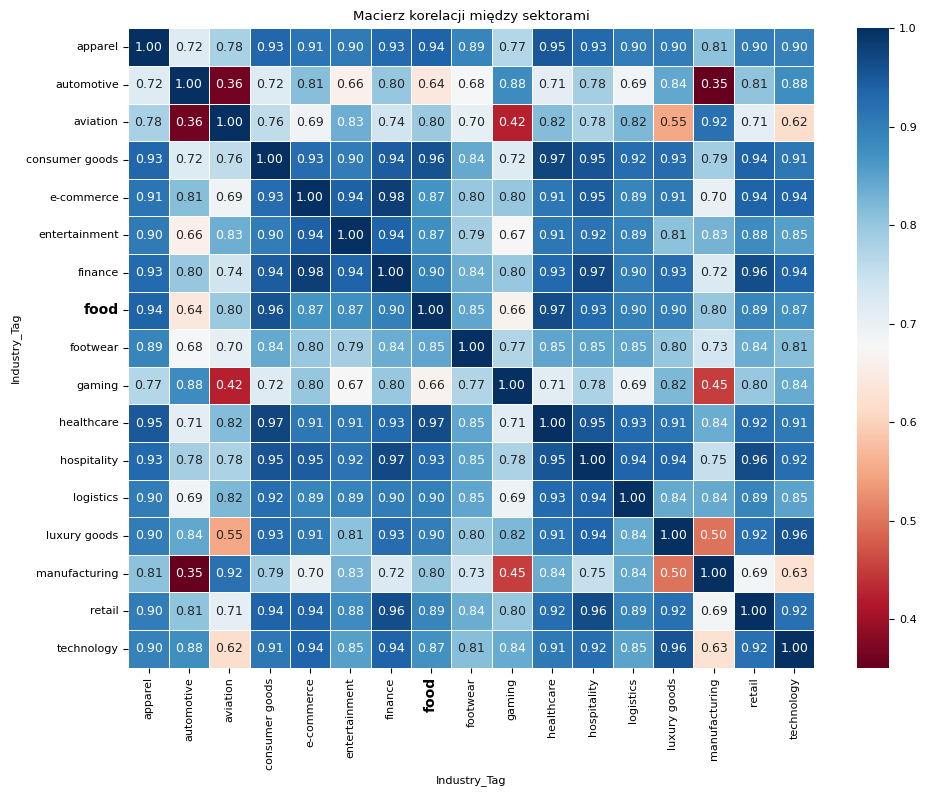

In [52]:
# ================================= Analiza korelacji =================================

# Korelacja
numeric_data = data_industry_weekly.select_dtypes(include='number')
correlation_matrix = numeric_data.corr()


plt.figure(figsize=(10, 8))
macierz = sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f', linewidths=0.5,
                          annot_kws={'size': 9})

# Pogrubienie wybranej nazwy na osi X
for label in macierz.get_xticklabels():
    if label.get_text() == sektor_Y:
        label.set_weight('bold')
        label.set_fontsize(10)

# Pogrubienie wybranej nazwy na osi Y
for label in macierz.get_yticklabels():
    if label.get_text() == sektor_Y:
        label.set_weight('bold')
        label.set_fontsize(10)

plt.title(f'Macierz korelacji między sektorami')
plt.tight_layout()
plt.show()



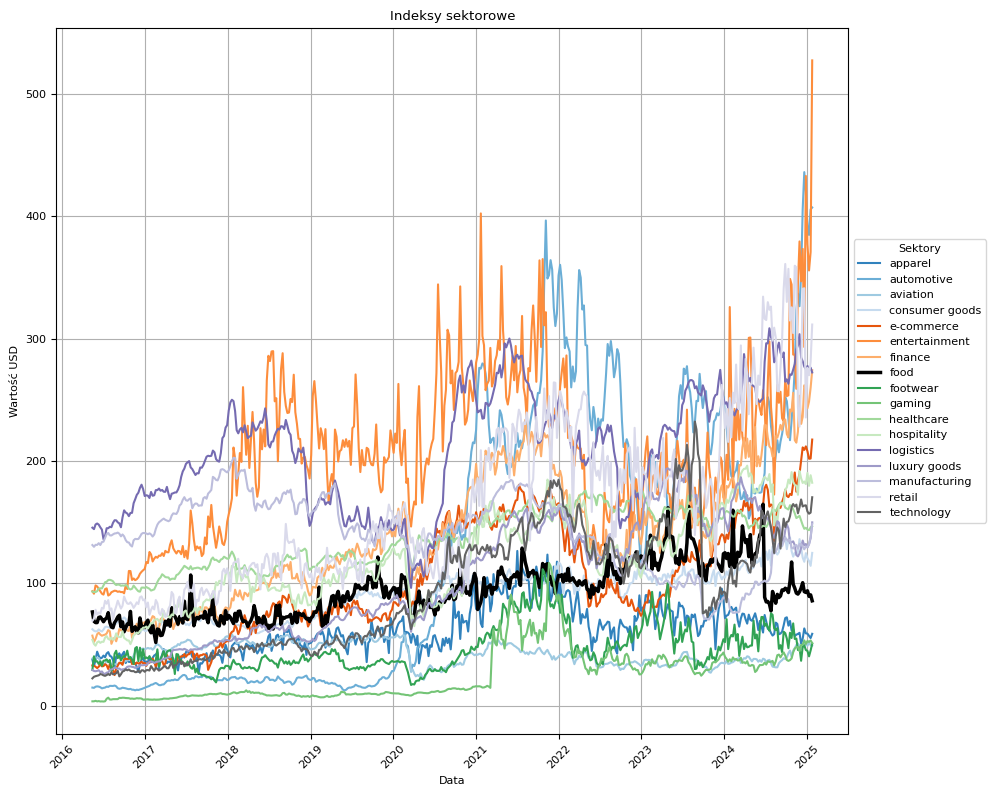

In [53]:
# ============================= Wykres liniowy =============================

# Wykres liniowy tylko dla wybranego okna czasowego (train+test)
data_industry_shortened = data_industry_weekly.tail(TRAIN_SIZE + TEST_SIZE + LAG_WEEKS)

plt.figure(figsize=(10, 8))
palette = sns.color_palette('tab20c', n_colors=len(data_industry_shortened.columns[1:]))

# Iterowanie po zmiennych i ich wykres
for i, column in enumerate(data_industry_shortened.columns[1:]):  # iterujemy po indeksie oraz po nazwie kolumny
    if column == sektor_Y:
        # Wyróżnienie koloru i grubości dla wybranej zmiennej
        plt.plot(data_industry_shortened['Date'], data_industry_shortened[column], label=column, color='black', linewidth=2.5)
    else:
        plt.plot(data_industry_shortened['Date'], data_industry_shortened[column], label=column, color=palette[i])

# Dostosowanie wykresu
plt.title('Indeksy sektorowe')
plt.xlabel('Data')
plt.ylabel('Wartość USD')
plt.legend(title='Sektory', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(rotation=45)

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()



In [54]:
# =============================== Zmienne opóźnione ===============================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH OPÓŹNIONYCH (' + str(LAG_WEEKS) + ' weeks) ~~~~~~~~~~~~~~~~~~~~')

data_industry_filtered = data_industry_weekly.drop(columns='Date')  # usuwamy kolumnę z datą

# Utworzenie zmiennych opóźnionych (do szeregu czasowego żeby móc wykorzystać xgboost)
data_lagged = create_lags(data_industry_filtered, LAG_WEEKS, sektor_Y)
data_lagged = data_lagged.dropna()

statistics(data_lagged, 'dane z indeksami sektorowymi i opóźnieniami')


# ============================= Przygotowanie zbioru do modelowania ================================================================

X = data_lagged.drop(columns=sektor_Y)  # Wszystkie kolumny oprócz Y
y = data_lagged[sektor_Y]               # Zmienna docelowa




~~~~~~~~~~~~~~~~~~~~ PRZYGOTOWANIE DANYCH OPÓŹNIONYCH (5 weeks) ~~~~~~~~~~~~~~~~~~~~

Statystyki dla danych:  dane z indeksami sektorowymi i opóźnieniami
                       food apparel_lag_1 apparel_lag_2 apparel_lag_3 apparel_lag_4 apparel_lag_5 automotive_lag_1 automotive_lag_2 automotive_lag_3 automotive_lag_4 automotive_lag_5 aviation_lag_1 aviation_lag_2 aviation_lag_3 aviation_lag_4 aviation_lag_5 consumer goods_lag_1 consumer goods_lag_2 consumer goods_lag_3 consumer goods_lag_4 consumer goods_lag_5 e-commerce_lag_1 e-commerce_lag_2 e-commerce_lag_3 e-commerce_lag_4 e-commerce_lag_5 entertainment_lag_1 entertainment_lag_2 entertainment_lag_3 entertainment_lag_4 entertainment_lag_5 finance_lag_1 finance_lag_2 finance_lag_3 finance_lag_4 finance_lag_5 food_lag_1 food_lag_2 food_lag_3 food_lag_4 food_lag_5 footwear_lag_1 footwear_lag_2 footwear_lag_3 footwear_lag_4 footwear_lag_5 gaming_lag_1 gaming_lag_2 gaming_lag_3 gaming_lag_4 gaming_lag_5 healthcare_lag_1 healthcare_lag_

In [55]:
# ============================= Group Lasso do wyboru zmiennych =================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ GRUPOWANIE ZMIENNYCH (GROUP LASSO) ~~~~~~~~~~~~~~~~~~~~')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tworzenie słownika grup i przypisywanie kolumn
grouped_X = {f'{group}_group': [col for col in X.columns if group in col] for group in industries}

# Wyświetlenie wyników
for group_name, cols in grouped_X.items():
    print(f'{group_name}: {cols}')

# Numerowanie grup
group_map = {group_name: i for i, group_name in enumerate(grouped_X.keys())}

# Lista grup dla każdej kolumny (konwersja do listy)
column_to_group = []
for group_name, columns in grouped_X.items():
    group_number = group_map[group_name]
    column_to_group.extend([group_number] * len(columns))

group_lasso = GroupLasso(
    groups=column_to_group,   # Lista numerów grup
    group_reg=0.1,            # Siła regularyzacji dla grup, jeśli dana grupa cech zostanie uznana za nieistotną, wszystkie cechy w tej grupie będą miały współczynniki równe 0, a żadna z nich nie znajdzie się w selected_features
    l1_reg=0.1,               # Siła regularyzacji L1, może wyzerować współczynniki pojedynczych cech w ramach grupy, nawet jeśli sama grupa jako całość jest zachowana
    scale_reg='none',         # Skalowanie kar w zależności od wielkości grupy (brak bo grupy są takie same wielkościowo)
    supress_warning=True,
    n_iter=5000
)

group_lasso.fit(X_scaled, y)

# Wybrane zmienne na podstawie współczynników
coefficients = group_lasso.coef_.ravel()  # Przekształcenie na wektor 1-wymiarowy
features_lasso = X.columns[coefficients != 0]

# Tworzenie DataFrame z nazwami cech i ich współczynnikami
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients})

coefficients_df = coefficients_df[coefficients_df['Coefficient'] != 0]

print('\nWybrane cechy po analizie Group Lasso: \n', coefficients_df.sort_values(by='Feature', ascending=True))

X_po_lasso = X[features_lasso]  # Tylko zmienne wybrane w poprzednim kroku




~~~~~~~~~~~~~~~~~~~~ GRUPOWANIE ZMIENNYCH (GROUP LASSO) ~~~~~~~~~~~~~~~~~~~~
fitness_group: []
healthcare_group: ['healthcare_lag_1', 'healthcare_lag_2', 'healthcare_lag_3', 'healthcare_lag_4', 'healthcare_lag_5']
footwear_group: ['footwear_lag_1', 'footwear_lag_2', 'footwear_lag_3', 'footwear_lag_4', 'footwear_lag_5']
gaming_group: ['gaming_lag_1', 'gaming_lag_2', 'gaming_lag_3', 'gaming_lag_4', 'gaming_lag_5']
food_group: ['food_lag_1', 'food_lag_2', 'food_lag_3', 'food_lag_4', 'food_lag_5']
entertainment_group: ['entertainment_lag_1', 'entertainment_lag_2', 'entertainment_lag_3', 'entertainment_lag_4', 'entertainment_lag_5']
technology_group: ['technology_lag_1', 'technology_lag_2', 'technology_lag_3', 'technology_lag_4', 'technology_lag_5']
retail_group: ['retail_lag_1', 'retail_lag_2', 'retail_lag_3', 'retail_lag_4', 'retail_lag_5']
manufacturing_group: ['manufacturing_lag_1', 'manufacturing_lag_2', 'manufacturing_lag_3', 'manufacturing_lag_4', 'manufacturing_lag_5']
logistics_gr

In [56]:
#=============================== Podział na zbiór treningowy i testowy ===================================================================
#Ze względu na analizę szeregu czasowego nie możemy podzielić zbioru w sposób losowy
#Rozmiary TRAIN_SIZE i TEST_SIZE podano na początku skryptu

X_train = X_po_lasso[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]  # Ostatnie TRAIN_SIZE próbek przed testowymi
y_train = y[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]
X_test = X_po_lasso[-TEST_SIZE:]    #najnowsze próbki (TEST_SIZE)
y_test = y[-TEST_SIZE:]

print('\n~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy po analize Group Lasso ~~~~~~~~~~~~~~~~~~~~')
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)




~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy po analize Group Lasso ~~~~~~~~~~~~~~~~~~~~
X_train:  (400, 14)
y_train:  (400,)
X_test:  (50, 14)
y_test:  (50,)


In [57]:
# ================ Model XGBoost - do kolejnej selekcji zmiennych według feature importance  ===============================

model=xgb.XGBRegressor()
model.fit(X_train, y_train)

# Predykcje
y_pred = model.predict(X_test)

# Gain importance
gain_importance = model.get_booster().get_score(importance_type='gain')

# Tworzenie DataFrame na podstawie nazwy cech i ich Gain z gain_importance
importance_df = pd.DataFrame(list(gain_importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Obliczenie skumulowanej ważności
importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum() / importance_df['Importance'].sum()

# Wybranie cech do 99% skumulowanej ważności (usunięcie zmiennych najmniej ważnych - szum)
selected_features = importance_df[importance_df['Cumulative_Importance'] <= 0.99]['Feature'].tolist()

print('\nWybrano cechy według Feature Importance: ', len(selected_features), selected_features)

X_final = X_po_lasso[selected_features]

print('\nZaktualizowany zbiór X:', X_final.shape)


Wybrano cechy według Feature Importance:  11 ['food_lag_1', 'healthcare_lag_2', 'food_lag_2', 'healthcare_lag_1', 'food_lag_5', 'healthcare_lag_5', 'food_lag_3', 'food_lag_4', 'healthcare_lag_3', 'healthcare_lag_4', 'apparel_lag_4']

Zaktualizowany zbiór X: (987, 11)


In [58]:
# ============================ Optuna do optymalizacji hiperparametrów ============================================================================
print('\n~~~~~~~~~~~~~~~~~~~~ Optymalizacja hiperparametrów modelu ~~~~~~~~~~~~~~~~~~~~')
study = optuna.create_study(direction='minimize')

study.optimize(lambda trial: objective(trial, X_final, y, TRAIN_SIZE, VAL_SIZE, TEST_SIZE), n_trials=ITERATIONS, timeout=3600, n_jobs=10)

# Najlepsze parametry
print('\nNajlepsze parametry: ', study.best_params)


[I 2025-01-26 22:35:57,751] A new study created in memory with name: no-name-47ea7465-15ef-4f3d-83b3-efefc2fd9c24



~~~~~~~~~~~~~~~~~~~~ Optymalizacja hiperparametrów modelu ~~~~~~~~~~~~~~~~~~~~


[I 2025-01-26 22:35:59,710] Trial 2 finished with value: 19.39911054091967 and parameters: {'learning_rate': 0.011763441602965146, 'reg_alpha': 4.142219657585578, 'reg_lambda': 2.7451401846742858}. Best is trial 2 with value: 19.39911054091967.
[I 2025-01-26 22:35:59,874] Trial 9 finished with value: 18.466921034395675 and parameters: {'learning_rate': 0.015609539267256433, 'reg_alpha': 3.998578699575108, 'reg_lambda': 3.4253573472043923}. Best is trial 9 with value: 18.466921034395675.
[I 2025-01-26 22:35:59,891] Trial 0 finished with value: 19.224894502191532 and parameters: {'learning_rate': 0.012347294986411848, 'reg_alpha': 1.3523011525260409, 'reg_lambda': 3.144617274959893}. Best is trial 9 with value: 18.466921034395675.
[I 2025-01-26 22:36:00,014] Trial 1 finished with value: 17.655881748647587 and parameters: {'learning_rate': 0.022141729968902294, 'reg_alpha': 4.436587199779386, 'reg_lambda': 3.898713310482602}. Best is trial 1 with value: 17.655881748647587.
[I 2025-01-26 2


Najlepsze parametry:  {'learning_rate': 0.08057533726562205, 'reg_alpha': 0.3286829395452712, 'reg_lambda': 1.2105435282285946}



~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy do XGBoost (final model) ~~~~~~~~~~~~~~~~~~~~
X_train:  (400, 11)
y_train:  (400,)
X_test:  (50, 11)
y_test:  (50,)

RMSE modelu (trening): 1.22
MAPE modelu (trening): 0.98 %

RMSE modelu (okres testowy): 12.22
MAPE modelu (okres testowy): 8.62 %


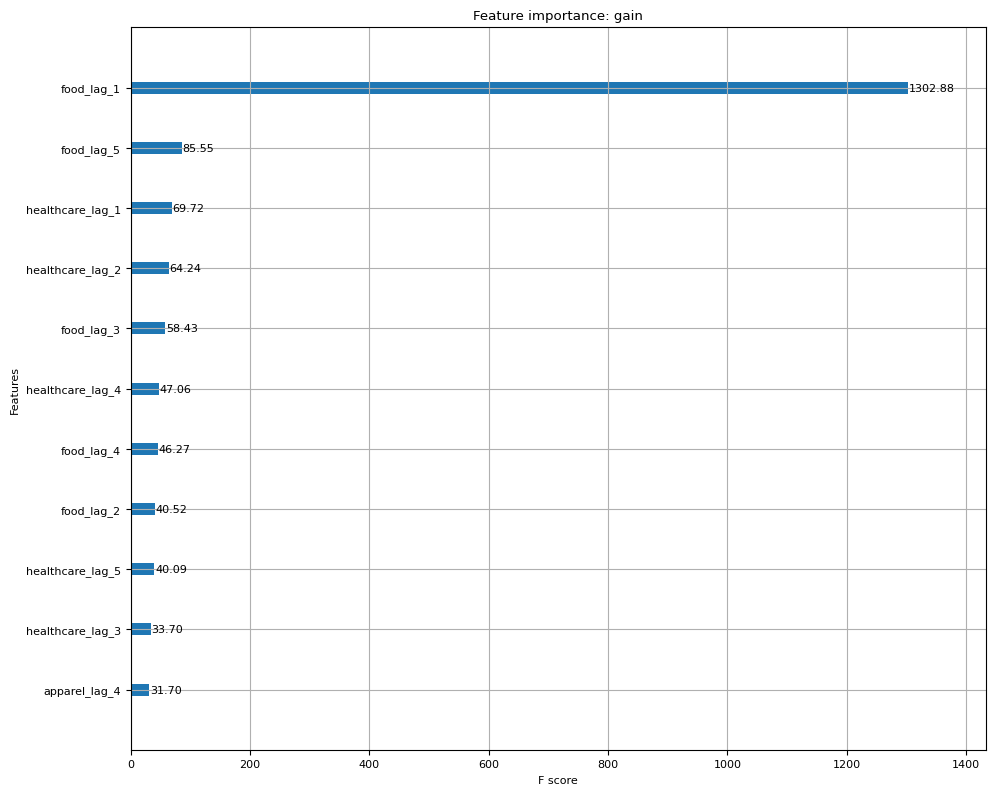

In [59]:
# =============================== Model XGBoost - trening ===============================================================================

best_params = study.best_params  # hiperparametry z Optuny

print('\n~~~~~~~~~~~~~~~~~~~~ Zbiór treningowy i testowy do XGBoost (final model) ~~~~~~~~~~~~~~~~~~~~')
X_train = X_final[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]  #najnowsze TRAIN_SIZE próbek przed testowymi
y_train = y[-(TRAIN_SIZE + TEST_SIZE):-TEST_SIZE]
X_test = X_final[-TEST_SIZE:]    #najnowsze próbki (TEST_SIZE)
y_test = y[-TEST_SIZE:]

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

y_pred_train=final_model.predict(X_train)

train_rmse = np.sqrt(np.mean((y_pred_train - y_train) ** 2))
train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
print('\nRMSE modelu (trening):', round(train_rmse, 2))
print('MAPE modelu (trening):', round(train_mape, 2), '%')

# Prognoza i ocena
y_pred = final_model.predict(X_test)
final_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
final_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('\nRMSE modelu (okres testowy):', round(final_rmse, 2))
print('MAPE modelu (okres testowy):', round(final_mape, 2), '%')

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(final_model, importance_type='gain', ax=ax,values_format='{v:.2f}')
ax.set_title('Feature importance: gain')
plt.tight_layout()
plt.show()


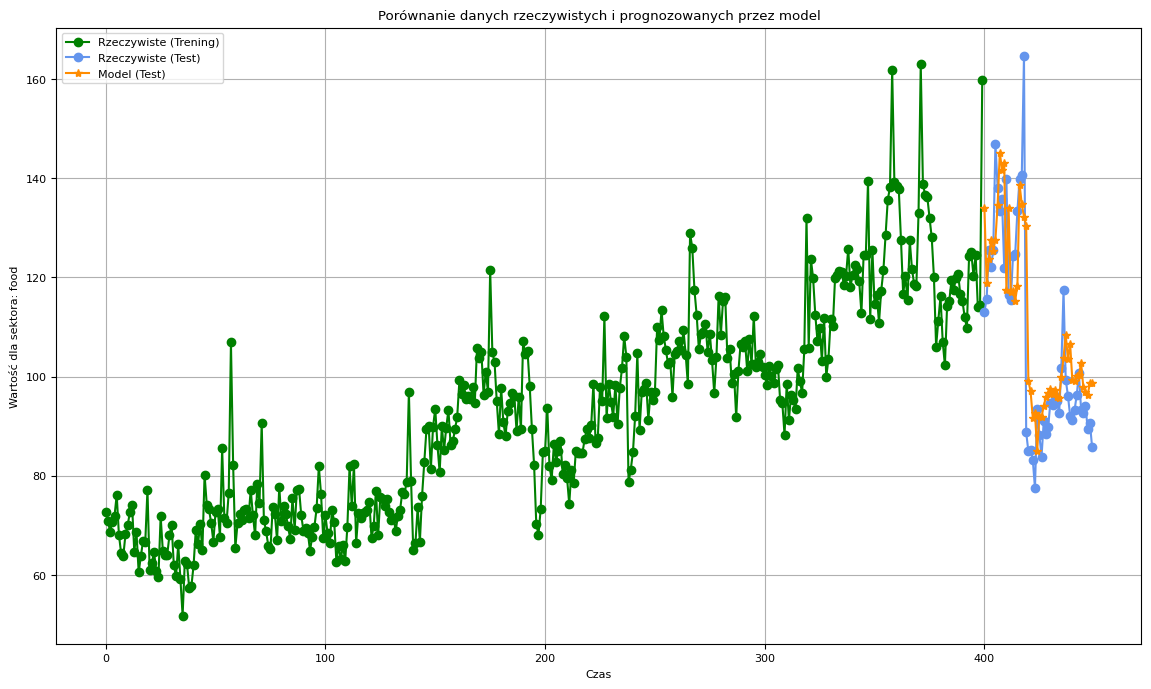

In [60]:
# ============================= Model XGBoost vs rzeczywiste WYKRES ========================================================================================
# Indeksy czasowe dla danych treningowych i testowych
train_steps = np.arange(len(y_train))                             # Indeksy dla treningu
test_steps = np.arange(len(y_train), len(y_train) + len(y_test))  # Indeksy dla testu (kontynuacja po treningu)

plt.figure(figsize=(14, 8))

# Rzeczywiste dane
plt.plot(train_steps, y_train, label='Rzeczywiste (Trening)', color='green', marker='o')
plt.plot(test_steps, y_test, label='Rzeczywiste (Test)', color='cornflowerblue', marker='o')

# Prognozy modelu na zbiorze testowym
plt.plot(test_steps, y_pred, label='Model (Test)', color='darkorange', marker='*')

# Dostosowanie wykresu
plt.title('Porównanie danych rzeczywistych i prognozowanych przez model')
plt.xlabel('Czas')
plt.ylabel(f'Wartość dla sektora: {sektor_Y}')
plt.legend()
plt.grid(True)
plt.show()


========================== Shapley values ==========================
Wpływ poszczególnych zmiennych na predykcję:


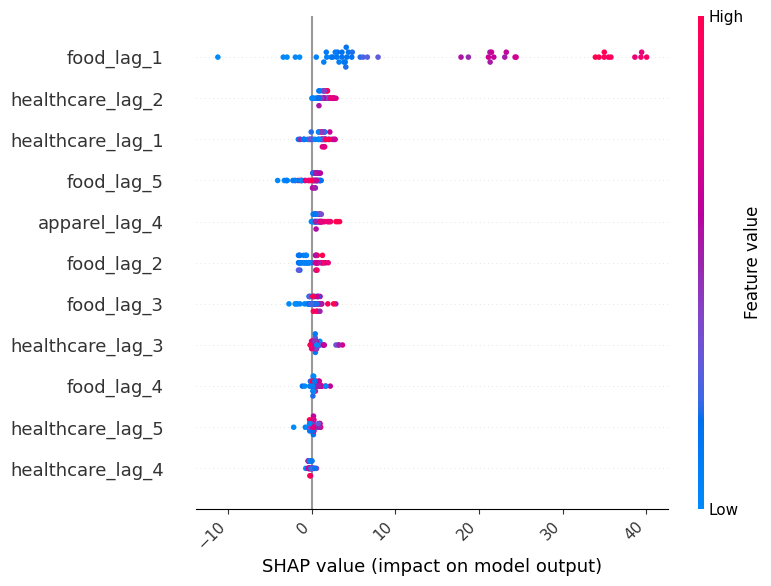

In [61]:
# ============================= Shapley values ====================================================================================================
print('========================== Shapley values ==========================')
print('Wpływ poszczególnych zmiennych na predykcję:')
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(X_test)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)    # Wpływ cech na przewidywaną wartość modelu
plt.xticks(rotation=45, ha='right')                   # Ustawienie kąta nachylenia etykiet osi
plt.tight_layout()                                    # Automatyczne dopasowanie marginesów
plt.show()



~~~~~~~~~~~~~~~~~~~~ PROGNOZA NA TYDZIEŃ: 2025-01-25 - 2025-01-31 ~~~~~~~~~~~~~~~~~~~~

Prognoza wartości indeksu:  [94.422844]
Wartość indeksu w obecnym tygodniu: 85.82173587553427

Rekomendacja dla sektora food: KUP 🟢


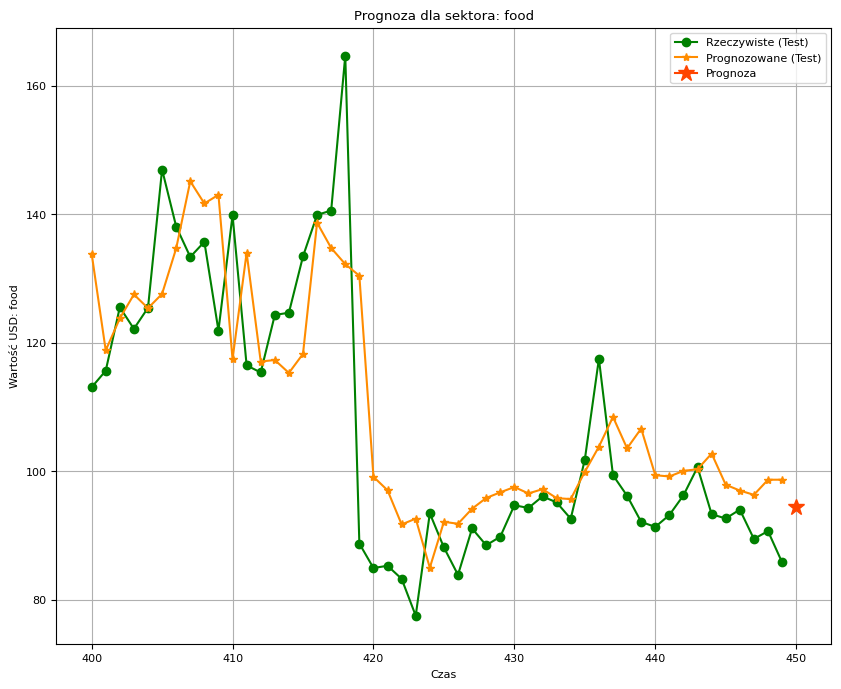


========================== Waterfall Plot ==========================


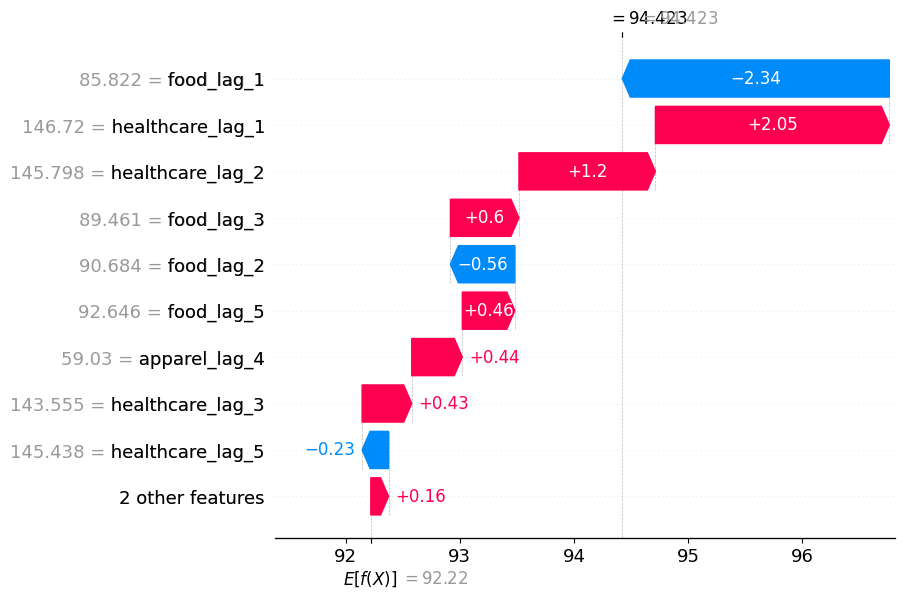


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ KONIEC ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [62]:
# ============================== PROGNOZA NA KOLEJNY TYDZIEŃ ================================================================================================
data_od = newest_date + timedelta(days=1)
data_do = data_od + timedelta(days=6)
print(f'\n~~~~~~~~~~~~~~~~~~~~ PROGNOZA NA TYDZIEŃ: {data_od} - {data_do} ~~~~~~~~~~~~~~~~~~~~')

# Tworzenie nowego wiersza
new_row = {}

for col in X_test.columns:
    lag_number = int(col[-1])  # Pobieranie numeru lag
    if lag_number == 1:
        # Wartości dla '_lag_1' pochodzą z danych pierwotnych (bez opóźnień)
        col_orginal = col.split('_')[0]
        new_row[col] = data_industry_weekly[col_orginal].iloc[-1]
    else:
        # Wartości dla '_lag_2', '_lag_3', itd. pochodzą  z kolumny o numerze lag-1 ze zbioru danych opóźnionych
        previous_col = col.replace(f'_lag_{lag_number}', f'_lag_{lag_number - 1}')
        new_row[col] = data_lagged[previous_col].iloc[-1]

new_row_df = pd.DataFrame([new_row])  # Do dataframe
y_pred_next = final_model.predict(new_row_df)
print('\nPrognoza wartości indeksu: ', y_pred_next)

y_pred_last = y_test.iloc[-1]
print('Wartość indeksu w obecnym tygodniu:', y_pred_last)
if y_pred_next > y_pred_last:
    print(f'\nRekomendacja dla sektora {sektor_Y}: KUP \U0001F7E2')
else:
    print(f'\nRekomendacja dla sektora {sektor_Y}: SPRZEDAJ \U0001F534')

# Wykres z prognozą na kolejny tydzień
test_steps = np.arange(len(y_train), len(y_train) + len(y_test))                      # Indeksy dla testu (kontynuacja po treningu)
progn_steps = np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 1)   # Indeks dla predykcji (kontynuacja po testowym)

plt.figure(figsize=(10, 8))
# Rzeczywiste dane
plt.plot(test_steps, y_test, label='Rzeczywiste (Test)', color='green', marker='o')
# Prognozy modelu na zbiorze testowym
plt.plot(test_steps, y_pred, label='Prognozowane (Test)', color='darkorange', marker='*')
# Prognoza kolejnego tygodnia
plt.plot(progn_steps, y_pred_next, label='Prognoza', color='orangered', marker='*', markersize=12)

# Dostosowanie wykresu
plt.title(f'Prognoza dla sektora: {sektor_Y}')
plt.xlabel('Czas')
plt.ylabel(f'Wartość USD: {sektor_Y}')
plt.legend()
plt.grid(True)
plt.show()

# Waterfall Plot (wpływ poszczególnych zmiennych na prognozę)
print('\n========================== Waterfall Plot ==========================')
explainer = shap.TreeExplainer(final_model)
shap_values = explainer(new_row_df)
shap.plots.waterfall(shap_values[-1])

print(f'\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ KONIEC ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')